# SAR and Speckle
Synthetic aperture radar utilizes microwave-frequency light to actively image surface features. For example, the satelittes of the ESA's Sentinel-1  mission emit C-band (4 to 8 Ghz) radiation and analyze the returnimg backscatter of this radiation off of surface features to create a map of those features. One of the consequences of using microwave-frequency light to image surface features is that the features being imaged often have a roughness with length scales similar to the wavelength of the light being used (4 to 8 cm). So, the backscattered light will experience mutual interference creating speckle noise. Speckle noise presents itself as patches that are lighter or darker than they otherwise would be based on the features being imaged. 

Image processing techniques to reduce speckle noise are called despeckling techniques. Here I take a closer look at speckle noise in the iceberg/ship dataset of the Statoil /C-CORE Iceberg Classifier Challenge and employ a filter called the Lee Filter to reduce this noise.

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.ndimage.filters import uniform_filter

train_data = pd.read_json('./input/train.json')

Here is an example image from the dataset with band 2 shown separately

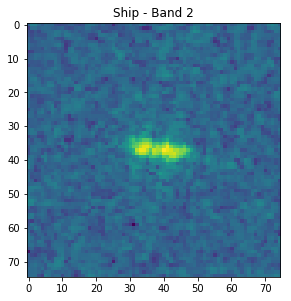

In [21]:
row = train_data.sample(1)
title_str = 'Iceberg' if row['is_iceberg'].values == 1 else 'Ship'

band_1 = np.reshape(row['band_1'].values.tolist(), (75, 75))
band_2 = np.reshape(row['band_2'].values.tolist(), (75, 75))

fig = plt.figure(0, figsize=(10, 10))
ax = fig.add_subplot(1, 2, 1)
ax.set_title(title_str + ' - Band 2')
ax.imshow(band_2)
plt.show()


The raw image band data is given in units of decibels, so I'll convert to linear units assuming the raw data is given by:
Z(dB) = 10 log10(Z/Z_0) and Z_0 is 1.

In [22]:
# implement functions to convert SAR data from decibel units to linear units and back again
def decibel_to_linear(band):
    return np.power(10, np.array(band) / 10)


def linear_to_decibel(band):
    return 10 * np.log10(band)


## The Additive Noise Lee Despeckling Filter
Let's assume that the despeckling noise is additive with a constant mean of zero, a constant variance, and drawn from a Gaussian distribution. Use a window (I x J pixels) to scan the image with a stride of 1 pixels (and I will use reflective boundary conditions). The despeckled value of the pixel in the center of the window located in the ith row and jth column is,
zhat_ij = mu_k + W*(z_ij - mu_z),
where mu_k is the mean value of all pixels in the window centered on pixel i,j, z_ij is the unfiltered value of the pixel, and W is a weight calculated as,
W = var_k / (var_k + var_noise),
where var_k is the variance of all pixels in the window and var_noise is the variance of the speckle noise. A possible alternative to using the actual value of the center pixel for z_ij is to use the median pixel value in the window. 

The parameters of the filter are the window/kernel size and the variance of the noise (which is unknown but can perhaps be estimated from the image as the variance over a uniform feature smooth like the surface of still water). Using a larger window size and noise variance will increase radiometric resolution at the expense of spatial resolution. 

For more info on the Lee Filter and other despeckling filters see http://desktop.arcgis.com/en/arcmap/10.3/manage-data/raster-and-images/speckle-function.htm

In [23]:
def lee_filter(band, window, var_noise=0.25):
    mean_window = uniform_filter(band, window)
    mean_sqr_window = uniform_filter(band ** 2, window)
    var_window = mean_sqr_window - mean_window ** 2

    weights = var_window / (var_window + var_noise)
    band_filtered = mean_window + weights * (band - mean_window)
    return band_filtered


Let's see what effect despeckling has on the images. Below the images above (band 1 and band 2) are despeckled using three different window sizes and three different speckle noise variance levels estimated as multiples of the variance over the entire band.  Images of the data retransformed back into decibels are also shown.

In [24]:
windows = [2, 4, 8]  # can be tuple too if not symetric
noise_var = np.array([1, 2, 4])
band_2_linear = decibel_to_linear(band_2)

title_str_2 = title_str + ' Band 2\nWindow: {}, Noise Var: {}'
noise_var_2 = np.round(np.var(band_2_linear) * noise_var, 10)


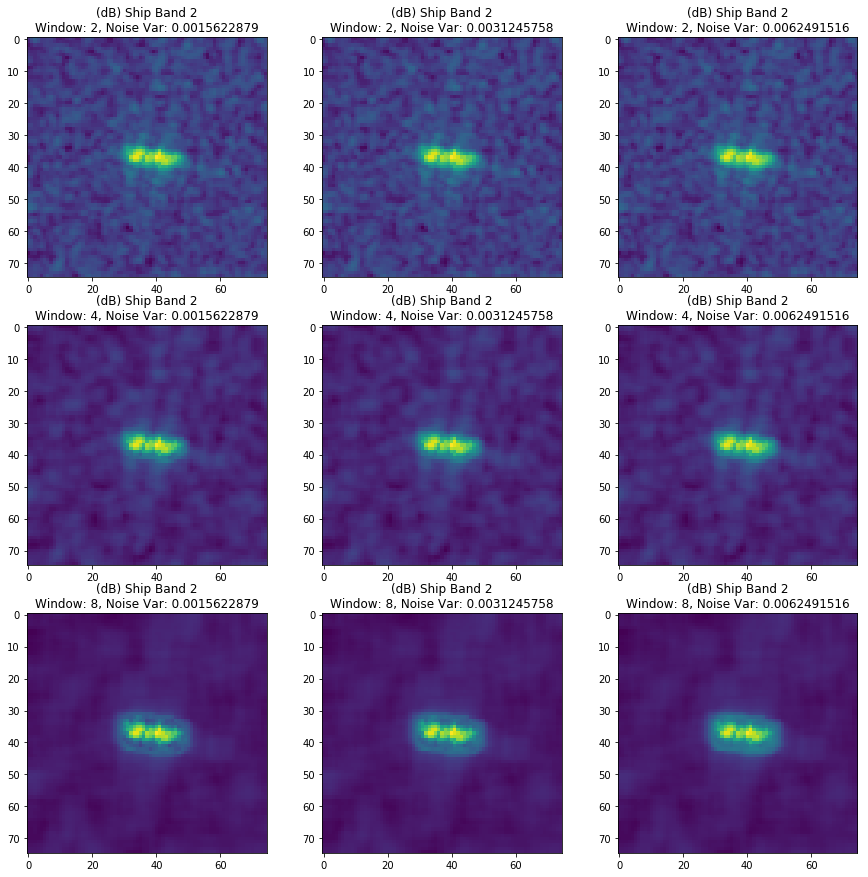

In [25]:
fig = plt.figure(4, figsize=(15, 15))
p = 0
for i in range(3):
    for j in range(3):
        p += 1
        ax = fig.add_subplot(3, 3, p)
        title = title_str_2.format(str(windows[i]), str(noise_var_2[j]))
        ax.set_title('(dB) ' + title)
        ax.imshow(linear_to_decibel(lee_filter(band_2_linear, windows[i], noise_var_2[j])))
plt.show()
